54
16
Best rho:  0.001   Op gap: : 3.167681799147448e-05
Best rho:  0.0014736842105263158   Op gap: : 1.834272922852931e-05
Best rho:  0.0019473684210526317   Op gap: : 1.2144665149302347e-05
Best rho:  0.0024210526315789475   Op gap: : 8.720941790260617e-06
Best rho:  0.0028947368421052633   Op gap: : 6.6242704212099435e-06
Best rho:  0.003368421052631579   Op gap: : 5.262558826893415e-06
Best rho:  0.003842105263157895   Op gap: : 4.362933502685684e-06
Best rho:  0.00431578947368421   Op gap: : 3.7965870567785442e-06
Best rho:  0.004789473684210527   Op gap: : 3.513748212613521e-06


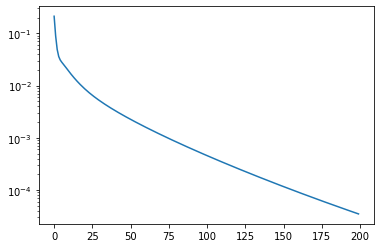

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os

import scipy
import networkx as nx

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from numpy import linalg as LA


# In[2]:


seed = 42
no_users = 16
lambda_logistic = 1e-3


# In[3]:


def random_split(X, y, n, seed):
    """Equally split data between n agents"""
    rng = np.random.default_rng(seed)
    perm = rng.permutation(y.size)
    X_split = np.array_split(X[perm], n)  #np.stack to keep as a np array
    y_split = np.array_split(y[perm], n)
    return X_split, y_split


# In[4]:


def loss(w, A, b, l2):
    z = b * np.dot(A, w)
    tmp = np.minimum(z, 0)
    loss = np.log((np.exp(tmp) + np.exp(tmp - z)) / np.exp(tmp))
    loss_sum = np.sum(loss) / len(b)
    reg = (np.linalg.norm(w) ** 2) * l2 / 2
    return loss_sum + reg


# In[5]:


def gradient(w, A, b, l2):
    m = A.shape[0]
    z = b * np.dot(A, w)
    tmp0 = np.minimum(z, 0)
    tmp1 = np.exp(tmp0 - z) / ((np.exp(tmp0) + np.exp(tmp0 - z)))
    tmp2 = - tmp1 * b
    res = np.dot(A.T, tmp2) / m + l2 * w
    return res


# In[6]:


def hessian(w, A, b, l2):
    Aw = A @ w
    activation = scipy.special.expit(Aw)
    weights = activation * (1-activation)
    A_weighted = np.multiply(A.T, weights)
    return A_weighted@A/A.shape[0] + l2*np.eye(A.shape[1])


# In[7]:


def degrees(A):
    """Return the degrees of each node of a graph from its adjacency matrix"""
    return np.sum(A, axis=0).reshape(A.shape[0], 1)


# In[8]:


def generate_graph(n, seed):
    """Generate a random connected graph"""
    while True:
        g = nx.generators.random_graphs.binomial_graph(n, 0.4, seed = seed) 
        # g = nx.random_geometric_graph(n, 0.4, seed = seed)
        #g = nx.grid_2d_graph(int(n/5), int(n/5))
        if nx.algorithms.components.is_connected(g):
            return g


# In[9]:


G = generate_graph(no_users, seed)
adjacency_matrix = nx.linalg.graphmatrix.adjacency_matrix(G)
print(G.number_of_edges())
print(G.number_of_nodes())
#nx.draw(G, with_labels=True, font_weight='bold')


# In[10]:


X = np.load('X.npy')
y = np.load('y.npy').ravel()

num_feature = X.shape[1] #+ 1 #+1 for bias


# In[11]:


X, y = random_split(X, y, no_users, seed)
0.002810053201064021
rhos = list(np.linspace(0.001, 0.01, num=20, endpoint=True, retstep=False, dtype=None, axis=0))

min_opgap = 10

best_rho = 10

for rho in rhos:

    theta = [np.zeros(num_feature) for _ in range(no_users)] # initial model

    d_new = [np.zeros(num_feature) for _ in range(no_users)] # direction
    d_old = [np.zeros(num_feature) for _ in range(no_users)] # old direction

    lamd = [np.zeros(num_feature) for _ in range(no_users)] # dual variables

    grad = [np.zeros(num_feature) for _ in range(no_users)] # old grads
    Hess = [np.zeros([num_feature, num_feature]) for _ in range(no_users)] # old hessians


    # In[12]:


    # Optimal objective function, i.e., f(x*)
    obj0 = 0.09154228921688996 # w8a dataset

    #n_iters = 200
    # rho0 = 0.01, per = 1, factor = 0.5
    #rho0 = 0.1
    #per = 1
    #factor = 0.85
    #alpha = 0.025
    #rho =[rho0*factor**(np.floor(t/per)) for t in range(n_iters)]
    # In[13]:


    n_iters = 200
    rho =[rho for t in range(n_iters)]
    alpha = 10 * rho[0] #0.045
    # Best: rho=0.003, alpha = 0.045
    # Best: rho=0.001, alpha = 0.025


    # In[14]:


    losses_dnl = []
    accuracies_dnl = []
    op_gap_dnl = np.zeros(shape=[n_iters])

    for k in range(n_iters):
        #print(k)
        for i in range(no_users):        
            grad[i] = gradient(theta[i], X[i], y[i], lambda_logistic)
            Hess[i] = hessian(theta[i], X[i], y[i], lambda_logistic)

        for i in range(no_users):
            w_neighbors_sum = np.zeros(num_feature)
            for j in G.neighbors(i):
                w_neighbors_sum = np.add(w_neighbors_sum, d_old[j])
            degree = G.degree(i)
            d_new[i] = np.matmul(np.linalg.inv(Hess[i] + (2 * degree * rho[k] + alpha) * np.eye(num_feature)),                                        grad[i] - lamd[i] + rho[k] * (degree * d_old[i] + w_neighbors_sum))



        # Dual Variable Update
        for i in range(no_users):
            w_neighbors_sum = np.zeros(num_feature)
            for j in G.neighbors(i):
                w_neighbors_sum = np.add(w_neighbors_sum, d_new[j])
            degree = G.degree(i)
            lamd[i] = lamd[i] + rho[k] * (degree * d_new[i] - w_neighbors_sum)
       # print('dual: ', LA.norm(lamd[0]))


        for i in range(no_users):
            theta[i] = theta[i] - d_new[i]
            d_old[i] = d_new[i]

       # Performance Check

        theta_avg = 1/no_users*sum(theta)

        for i in range(no_users):
            loss_dnl = np.mean([loss(theta_avg, X[i], y[i], lambda_logistic) for i in range(no_users)])
            losses_dnl.append(loss_dnl)

        op_gap_dnl[k] = np.abs(losses_dnl[-1] - obj0)
    #print("rho: ", rho[0], "  Op gap: :", min_opgap)
    
    if op_gap_dnl[-1] < min_opgap:
        min_opgap = op_gap_dnl[-1]
        best_rho = rho
        print("Best rho: ", rho[0], "  Op gap: :", min_opgap)


# # Optimality Gap

# In[15]:


import matplotlib.pyplot as plt
plt.semilogy(op_gap_dnl)
#plt.ylim([10**(-5),0.5])
np.save('op_gap_dnl', op_gap_dnl)

